# BMEN 509 Project - Image Segmentation Algorithm

### Date
March 29th, 2024

### Authors
Reuben Christian - UCID: 10149810  
Jacob Nguyen - UCID: 30087465  
Ty Pilling - UCID: 30112537  
Gary Fong - UCID: 10154089  


## Purpose

This algorithm identifies and counts cells using image segmentation. It segments images with a sequence of processing techniques, including histogram equalization, median filtering, thresholding, and finally edge detection.

We optimized the algorithm for detecting cells in the [CIL Project: P1723](http://cellimagelibrary.org/project/P1723?per_page=10&page=1) dataset, which consists of alpha-synuclein nuclei counterstained in blue against red or green.


## Notebook Setup

In [1]:
# Library Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import exposure
from skimage import feature
from math import sqrt

# Setup Jupyter notebook specifics
%matplotlib inline

# Numpy printing help
np.set_printoptions(precision=2)

In [2]:
data_directory = os.path.join('.', 'Data')
result_directory = os.path.join('.', 'Results')
image_prefix = '112006'

# Get a list of all files in the data directory
file_list = os.listdir(data_directory)

# Filter the list to include only files starting with the specified prefix
filtered_files = [file for file in file_list if file.startswith(image_prefix)]

# Check if the number of filtered files is equal to the expected number of images
expected_count = 35
if len(filtered_files) == expected_count:
    print('All images are present.')
else:
    print('Images are missing. Please make sure you have downloaded the data and placed it in the correct directory.')


All images are present.


## Image Processing

### Constants

In [9]:
# Filtering parameters
median_kernel_size = 5
gaussian_kernel_size = (5, 5)
gaussian_sigma = 0

# HSV min/max values
h_min = 80
s_min = 50
v_min = 50
h_max = 130
s_max = 255
v_max = 255
lower = np.array([h_min, s_min, v_min])
upper = np.array([h_max, s_max, v_max])

# Difference of Gaussian blob detection parameters
min_sigma = 8
max_sigma = 25


### Process and display each processing step on sample

Cell count: 139


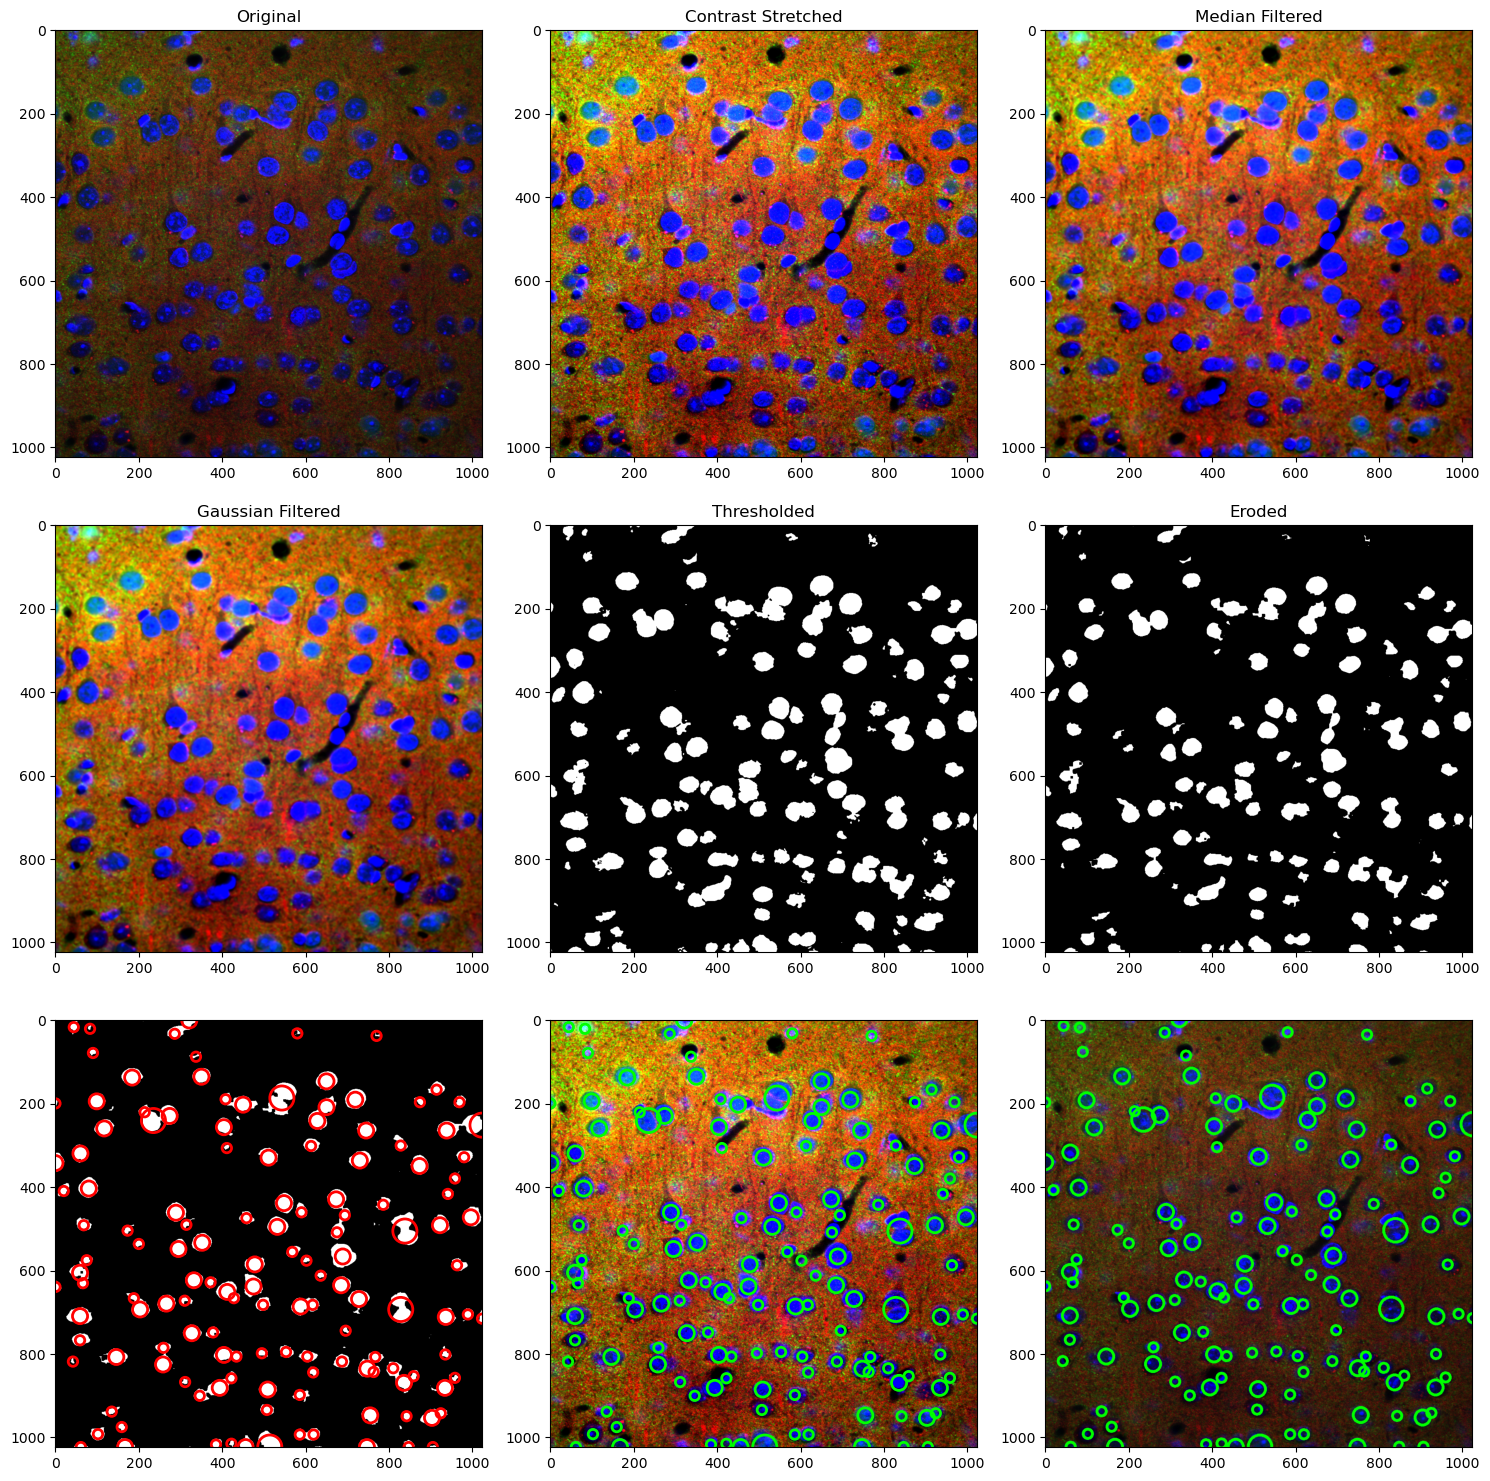

In [10]:
# Layout subplots
size = (3, 3)
plt.subplots(size[0], size[1], figsize=(15,15))

# Load original sample image
sample_image_name = '112006aaaa_RGB.tif'
image_path = os.path.join(data_directory, sample_image_name)
image = cv.imread(image_path)
rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.subplot(size[0], size[1], 1)
plt.imshow(rgb_image)
plt.title('Original')

# Contrast stretching
p5, p95 = np.percentile(rgb_image, (5, 95))
stretched_image = exposure.rescale_intensity(rgb_image, in_range=(p5, p95))
plt.subplot(size[0], size[1], 2)
plt.imshow(stretched_image)
plt.title('Contrast Stretched')

# Median filter
median_image = cv.medianBlur(stretched_image, median_kernel_size)
plt.subplot(size[0], size[1], 3)
plt.imshow(median_image)
plt.title('Median Filtered')

# Gaussian filter
gaussian_image = cv.GaussianBlur(median_image, gaussian_kernel_size, gaussian_sigma)
plt.subplot(size[0], size[1], 4)
plt.imshow(gaussian_image)
plt.title('Gaussian Filtered')

# Thresholding
hsv_image = cv.cvtColor(gaussian_image, cv.COLOR_RGB2HSV) # Convert to HSV color space
threshold_image = cv.inRange(hsv_image, lower, upper) # Create a binary mask of the image using the specified HSV range
plt.subplot(size[0], size[1], 5)
plt.imshow(threshold_image, cmap='gray')
plt.title('Thresholded')

# Erosion
eroded_image = cv.erode(threshold_image, np.ones((3,3), np.uint8), iterations=2)
plt.subplot(size[0], size[1], 6)
plt.imshow(eroded_image, cmap='gray')
plt.title('Eroded')

# Blob detection using Difference of Gaussian
blobs_dog = feature.blob_dog(eroded_image, min_sigma, max_sigma, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

# Overlay blobs on mask
plt.subplot(size[0], size[1], 7)
plt.imshow(eroded_image, cmap='gray')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    plt.gca().add_patch(c)

# Overlay blobs on contrast stretched image
plt.subplot(size[0], size[1], 8)
plt.imshow(stretched_image)
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    plt.gca().add_patch(c)

# Overlay blobs on original image
plt.subplot(size[0], size[1], 9)
for blob in blobs_dog:
    y, x, r = blob
    cv.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 5)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

# Count cells
cell_count = len(blobs_dog)
print(f'Cell count: {cell_count}')

plt.tight_layout()
plt.show()


In [11]:
from tabulate import tabulate

imageJ_results = [
    ('112006aaaa_RGB', 164),
    ('112006cccc_RGB', 116),
    ('112006dddd_RGB', 165),
    ('112006dddddd_RGB', 144),
    ('112006ffff_RGB', 81)
]

# Create a list to store the table data to print
table_data = []

# Loop over the data files
for file in filtered_files:
    # Load the original image
    image_path = os.path.join(data_directory, file)
    image = cv.imread(image_path)
    
    # Contrast stretching
    p5, p95 = np.percentile(image, (5, 95))
    stretched_image = exposure.rescale_intensity(image, in_range=(p5, p95))
    
    # Median filter
    median_image = cv.medianBlur(stretched_image, median_kernel_size)

    # Gaussian filter
    gaussian_image = cv.GaussianBlur(median_image, gaussian_kernel_size, gaussian_sigma)
    
    # Thresholding
    hsv_image = cv.cvtColor(gaussian_image, cv.COLOR_BGR2HSV) # Convert to HSV color space
    
    # Create a binary mask of the image using the specified HSV range
    threshold_image = cv.inRange(hsv_image, lower, upper)
    
    # Erosion
    eroded_image = cv.erode(threshold_image, np.ones((3,3), np.uint8), iterations=2)
    
    # Blob detection using Difference of Gaussian
    blobs_dog = feature.blob_dog(eroded_image, min_sigma, max_sigma, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
    
    # Count the cells
    cell_count = len(blobs_dog)
    
    # || Print the cell count ||
    image_name = file.replace('.tif', '')
    
    # Check if ImageJ results are available for the image
    cell_count_imageJ = None
    for result in imageJ_results:
        if result[0] == image_name:
            cell_count_imageJ = result[1]
            break
    
    # Append the data to the table
    table_data.append([image_name, cell_count, cell_count_imageJ])
    
    # Save the result image
    for blob in blobs_dog:
        y, x, r = blob
        cv.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 5)
    os.makedirs(result_directory, exist_ok=True)
    result_image_path = os.path.join(result_directory, 'Result_' + image_name + '.png')
    cv.imwrite(result_image_path, image)
    
# Print the table
headers = ['Image Name', 'Cell Count (Algorithm)', 'Cell Count (ImageJ)']
print(tabulate(table_data, headers=headers))
    



Image Name          Cell Count (Algorithm)    Cell Count (ImageJ)
----------------  ------------------------  ---------------------
112006aaaaaa_RGB                       107
112006aaaaa_RGB                        200
112006aaaa_RGB                         139                    164
112006aaa_RGB                           51
112006aa_RGB                            80
112006a_RGB                            157
112006bbbbbb_RGB                        68
112006bbbbb_RGB                        188
112006bbbb_RGB                          70
112006bb_RGB                            82
112006b_RGB                            176
112006cccccc_RGB                        47
112006ccccc_RGB                        178
112006cccc_RGB                          89                    116
112006dddddd_RGB                        79                    144
112006ddddd_RGB                        227
112006dddd_RGB                         107                    165
112006ddd_RGB                          167
11